## HW1-1  Deep VS Shallow 

## Simulate a Function

Model0 571
Model1 712
Model2 571


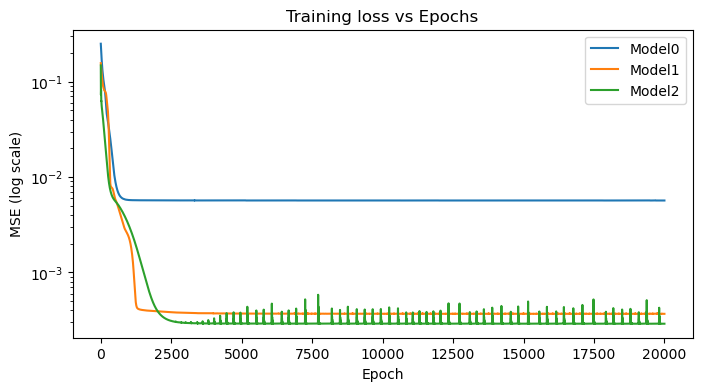

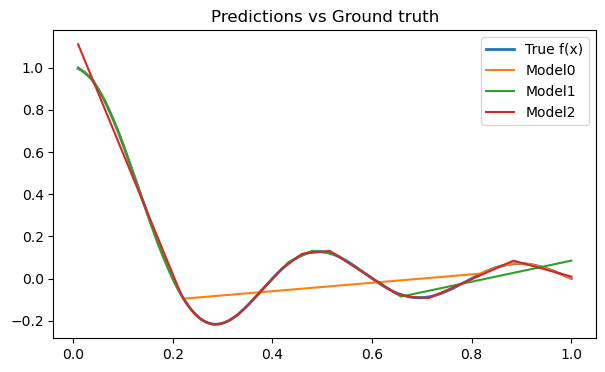

In [3]:
import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np, matplotlib.pyplot as plt


def f(x): return np.sin(5*np.pi*x)/(5*np.pi*x+1e-6)
X = np.linspace(0.01,1,400).reshape(-1,1).astype(np.float32)
y = f(X).astype(np.float32)

X_t = torch.from_numpy(X)
y_t = torch.from_numpy(y)


class Model0(nn.Module): 
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,5), nn.ReLU(),
            nn.Linear(5,10), nn.ReLU(),
            nn.Linear(10,10), nn.ReLU(),
            nn.Linear(10,10), nn.ReLU(),
            nn.Linear(10,10), nn.ReLU(),
            nn.Linear(10,10), nn.ReLU(),
            nn.Linear(10,5), nn.ReLU(),
            nn.Linear(5,1)
        )
    def forward(self,x): return self.net(x)

class Model1(nn.Module): 
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,10), nn.ReLU(),
            nn.Linear(10,18), nn.ReLU(),
            nn.Linear(18,15), nn.ReLU(),
            nn.Linear(15,10), nn.ReLU(),
            nn.Linear(10,4), nn.ReLU(),
            nn.Linear(4,1)
        )
    def forward(self,x): return self.net(x)

class Model2(nn.Module):  
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,190), nn.ReLU(),
            nn.Linear(190,1)
        )
    def forward(self,x): return self.net(x)

models = [Model0(), Model1(), Model2()]
names  = ["Model0","Model1","Model2"]


for m,n in zip(models,names):
    print(n, sum(p.numel() for p in m.parameters()))


def train_model(model, lr=1e-3, epochs=20000):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    losses = []
    for ep in range(epochs):
        opt.zero_grad()
        y_pred = model(X_t)
        loss = loss_fn(y_pred,y_t)
        loss.backward(); opt.step()
        losses.append(loss.item())
    return losses, model(X_t).detach().numpy()

histories, preds = [], []
for m in models:
    l,p = train_model(m, epochs=20000)
    histories.append(l); preds.append(p)

plt.figure(figsize=(8,4))
for l,n in zip(histories,names):
    plt.plot(l,label=n)
plt.yscale("log")
plt.xlabel("Epoch"); plt.ylabel("MSE (log scale)")
plt.legend(); plt.title("Training loss vs Epochs")
plt.show()


plt.figure(figsize=(7,4))
plt.plot(X,y,label="True f(x)",lw=2)
for p,n in zip(preds,names):
    plt.plot(X,p,label=n)
plt.legend(); plt.title("Predictions vs Ground truth")
plt.show()


## 1-1 Part B 

## Train on actual task

In [1]:
import itertools, random, math
from dataclasses import dataclass
from typing import List, Tuple

import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

def set_seed(seed=1337):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
DATASET = "mnist"  

if DATASET.lower() == "mnist":
    num_classes, in_ch = 10, 1
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    transform_test = transform_train
    train_set = datasets.MNIST("./data", train=True,  download=True, transform=transform_train)
    test_set  = datasets.MNIST("./data", train=False, download=True, transform=transform_test)
elif DATASET.lower() == "cifar10":
    num_classes, in_ch = 10, 3
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465), (0.2470,0.2435,0.2616)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465), (0.2470,0.2435,0.2616)),
    ])
    train_set = datasets.CIFAR10("./data", train=True,  download=True, transform=transform_train)
    test_set  = datasets.CIFAR10("./data", train=False, download=True, transform=transform_test)
else:
    raise ValueError("DATASET must be 'mnist' or 'cifar10'")

BATCH_SIZE = 128
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=512,     shuffle=False, num_workers=0, pin_memory=True)

num_classes, in_ch, len(train_set), len(test_set)


(10, 1, 60000, 10000)

In [3]:
class ShallowCNN(nn.Module):
    def __init__(self, in_ch, c1, c2, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, c1, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # /2
            nn.Conv2d(c1, c2, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # /2
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(c2, num_classes)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class DeepCNN(nn.Module):
    def __init__(self, in_ch, widths: List[int], num_classes: int):
        super().__init__()
        layers, prev = [], in_ch
        for i, w in enumerate(widths):
            layers += [nn.Conv2d(prev, w, 3, padding=1), nn.ReLU()]
            prev = w
            if (i+1) % 2 == 0:
                layers.append(nn.MaxPool2d(2))
        layers.append(nn.AdaptiveAvgPool2d((1,1)))
        self.features = nn.Sequential(*layers)
        self.fc = nn.Linear(prev, num_classes)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

def count_params(m): return sum(p.numel() for p in m.parameters())


In [4]:
def cnn_params_shallow(in_ch, c1, c2, num_classes):
   
    p = (c1*in_ch*9 + c1) + (c2*c1*9 + c2) + (c2*num_classes + num_classes)
    return p

def cnn_params_deep(in_ch, widths: List[int], num_classes):
    p, prev = 0, in_ch
    for w in widths:
        p += (w*prev*9 + w)
        prev = w
    p += prev*num_classes + num_classes
    return p

def find_matched_cnn_configs(in_ch, num_classes, target_params=200_000,
                             shallow_channels=(16,24,32,40,48,56,64,80,96,112,128),
                             deep_channels=(16,24,32,40,48,56,64),
                             deep_L_choices=(4,6),
                             exact_first=True, tol_ratio=0.01):
    

    shallow_cands = []
    for c1 in shallow_channels:
        for c2 in shallow_channels:
            ps = cnn_params_shallow(in_ch, c1, c2, num_classes)
            if abs(ps - target_params) / target_params <= 0.15:
                shallow_cands.append(((c1,c2), ps))
    shallow_cands.sort(key=lambda x: abs(x[1]-target_params))


    for L in deep_L_choices:
        for widths in itertools.product(deep_channels, repeat=L):
            pd = cnn_params_deep(in_ch, list(widths), num_classes)
            if exact_first:
                for (c1c2, ps) in shallow_cands:
                    if ps == pd:
                        return (c1c2, ps), (list(widths), pd)
 
    best = None
    for L in deep_L_choices:
        for widths in itertools.product(deep_channels, repeat=L):
            pd = cnn_params_deep(in_ch, list(widths), num_classes)
            for (c1c2, ps) in shallow_cands:
                diff = abs(ps - pd)
                if diff <= tol_ratio * max(ps, pd):
                    return (c1c2, ps), (list(widths), pd)
                if best is None or diff < best[0]:
                    best = (diff, (c1c2, ps), (list(widths), pd))
 
    return best[1], best[2]


TARGET_PARAMS = 120_000 if DATASET=="mnist" else 250_000

shallow_cfg, deep_cfg = find_matched_cnn_configs(
    in_ch=in_ch, num_classes=num_classes, target_params=TARGET_PARAMS,
    exact_first=True, tol_ratio=0.005
)

(c1, c2), p_shallow = shallow_cfg
widths, p_deep = deep_cfg
print(f"Dataset: {DATASET.upper()}")
print(f"Target ~{TARGET_PARAMS:,}")
print(f"Shallow config: c1={c1}, c2={c2} -> params={p_shallow:,}")
print(f"Deep config    : widths={widths} -> params={p_deep:,}  (equal? {p_shallow==p_deep})")


Dataset: MNIST
Target ~120,000
Shallow config: c1=96, c2=128 -> params=112,970
Deep config    : widths=[40, 16, 64, 56, 64, 56] -> params=112,970  (equal? True)


In [5]:
model_shallow = ShallowCNN(in_ch, c1, c2, num_classes).to(device)
model_deep    = DeepCNN(in_ch, widths, num_classes).to(device)

print("Param counts from PyTorch:")
print("  Shallow:", count_params(model_shallow))
print("  Deep   :", count_params(model_deep))


Param counts from PyTorch:
  Shallow: 112970
  Deep   : 112970


In [6]:
@dataclass
class History:
    tr_loss: list; tr_acc: list; te_loss: list; te_acc: list

def run_epoch(model, loader, opt=None):
    train = opt is not None
    model.train() if train else model.eval()
    loss_fn = nn.CrossEntropyLoss()
    tot_loss, tot_correct, n = 0.0, 0, 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fn(logits,y)
        if train:
            opt.zero_grad(); loss.backward(); opt.step()
        tot_loss += loss.item()*x.size(0)
        tot_correct += (logits.argmax(1)==y).sum().item()
        n += x.size(0)
    return tot_loss/n, tot_correct/n

def train_compare(modelA, modelB, epochs=10, lr=1e-3):
    optA = torch.optim.Adam(modelA.parameters(), lr=lr)
    optB = torch.optim.Adam(modelB.parameters(), lr=lr)
    H = History([],[],[],[])
    for ep in range(1, epochs+1):
        A_trL, A_trA = run_epoch(modelA, train_loader, optA)
        B_trL, B_trA = run_epoch(modelB, train_loader, optB)
        with torch.no_grad():
            A_teL, A_teA = run_epoch(modelA, test_loader)
            B_teL, B_teA = run_epoch(modelB, test_loader)
        H.tr_loss.append((A_trL, B_trL)); H.tr_acc.append((A_trA, B_trA))
        H.te_loss.append((A_teL, B_teL)); H.te_acc.append((A_teA, B_teA))
        print(f"[{ep:02d}/{epochs}] Shallow tr {A_trA*100:.2f}% te {A_teA*100:.2f}% | Deep tr {B_trA*100:.2f}% te {B_teA*100:.2f}%")
    return H

def plot_curves(H, title_prefix=""):
    ep = range(1, len(H.tr_loss)+1)
    # Loss
    plt.figure(figsize=(7,4))
    plt.plot(ep,[x[0] for x in H.tr_loss],label="Shallow Train")
    plt.plot(ep,[x[0] for x in H.te_loss],label="Shallow Test")
    plt.plot(ep,[x[1] for x in H.tr_loss],label="Deep Train")
    plt.plot(ep,[x[1] for x in H.te_loss],label="Deep Test")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{title_prefix} Loss"); plt.legend(); plt.show()
    # Acc
    plt.figure(figsize=(7,4))
    plt.plot(ep,[100*x[0] for x in H.tr_acc],label="Shallow Train")
    plt.plot(ep,[100*x[0] for x in H.te_acc],label="Shallow Test")
    plt.plot(ep,[100*x[1] for x in H.tr_acc],label="Deep Train")
    plt.plot(ep,[100*x[1] for x in H.te_acc],label="Deep Test")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title(f"{title_prefix} Accuracy"); plt.legend(); plt.show()


[01/8] Shallow tr 61.94% te 81.81% | Deep tr 87.96% te 97.06%
[02/8] Shallow tr 87.17% te 91.12% | Deep tr 97.77% te 98.54%
[03/8] Shallow tr 91.49% te 92.73% | Deep tr 98.44% te 98.54%
[04/8] Shallow tr 93.24% te 93.16% | Deep tr 98.90% te 98.94%
[05/8] Shallow tr 94.00% te 95.18% | Deep tr 99.05% te 98.78%
[06/8] Shallow tr 94.84% te 95.80% | Deep tr 99.22% te 99.04%
[07/8] Shallow tr 95.17% te 95.57% | Deep tr 99.30% te 99.14%
[08/8] Shallow tr 95.58% te 95.99% | Deep tr 99.42% te 99.28%


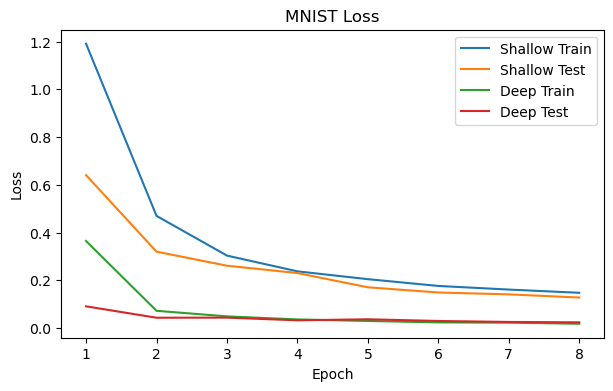

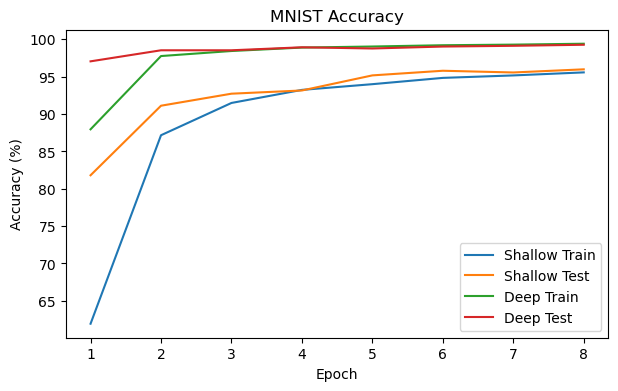


Final Test Accuracy:
  ShallowCNN: 95.99%
  DeepCNN   : 99.28%


In [32]:

EPOCHS = 8 if DATASET=="mnist" else 20
LR = 1e-3

hist = train_compare(model_shallow, model_deep, epochs=EPOCHS, lr=LR)
plot_curves(hist, title_prefix=DATASET.upper())

print("\nFinal Test Accuracy:")
print(f"  ShallowCNN: {hist.te_acc[-1][0]*100:.2f}%")
print(f"  DeepCNN   : {hist.te_acc[-1][1]*100:.2f}%")


### HW 1-2 Optimization 

## Visualize the optimization process

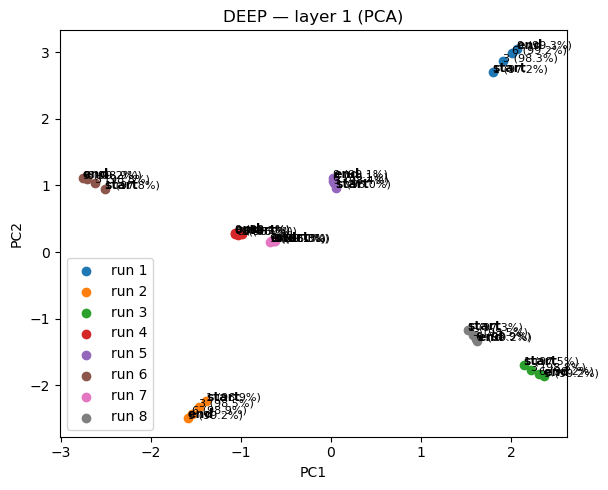

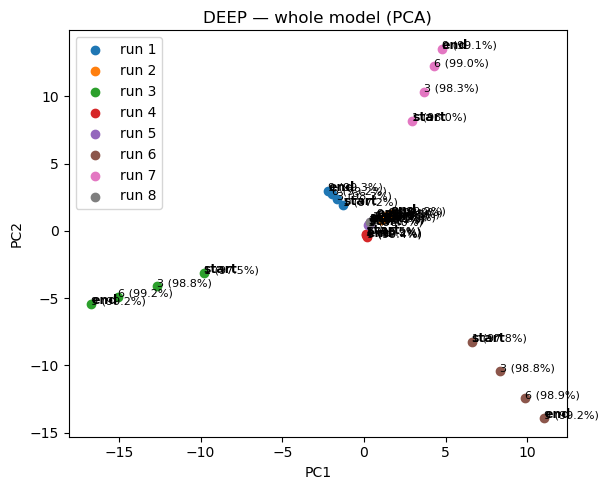

In [47]:

SNAPSHOT_EVERY = 3         
RUNS = 8                  
MODEL = "deep"             
EPOCHS_OPT = 9             
LR_OPT = 1e-3

def make_model(kind):
    return DeepCNN(in_ch, widths, num_classes).to(device) if kind=="deep" \
           else ShallowCNN(in_ch, c1, c2, num_classes).to(device)

def flatten_params(model, first_conv=False):
    vecs = []
    if first_conv:
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                vecs.append(m.weight.detach().view(-1).cpu().numpy())
                if m.bias is not None:
                    vecs.append(m.bias.detach().view(-1).cpu().numpy())
                break
    else:
        for p in model.parameters():
            vecs.append(p.detach().view(-1).cpu().numpy())
    return np.concatenate(vecs)

@torch.no_grad()
def test_accuracy(model):
    model.eval()
    correct = total = 0
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb).argmax(1)
        correct += (pred == yb).sum().item()
        total += yb.numel()
    return 100.0 * correct / total


all_runs = []  
for r in range(RUNS):
    set_seed(100 + r)
    model = make_model(MODEL)
    opt = torch.optim.Adam(model.parameters(), lr=LR_OPT)
    loss_fn = nn.CrossEntropyLoss()

    traj_whole, traj_l1, labels = [], [], []

    for ep in range(1, EPOCHS_OPT + 1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            opt.step()

        # snapshot?
        if ep % SNAPSHOT_EVERY == 0 or ep == 1:
            traj_whole.append(flatten_params(model, first_conv=False))
            traj_l1.append(flatten_params(model, first_conv=True))
            acc = test_accuracy(model)
            labels.append(f"{ep} ({acc:.1f}%)")  

    all_runs.append({
        "whole": np.stack(traj_whole),
        "l1":    np.stack(traj_l1),
        "labels": labels
    })


def global_pca_transform(all_runs, key):
    X = np.concatenate([r[key] for r in all_runs], axis=0) 
    mu = X.mean(0, keepdims=True)
    Xc = X - mu
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    W = Vt[:2].T                                            
    Z_per_run = [ (r[key] - mu) @ W for r in all_runs ]
    return Z_per_run

Z_l1    = global_pca_transform(all_runs, "l1")
Z_whole = global_pca_transform(all_runs, "whole")


def scatter_runs(Z_runs, all_labels, title):
    plt.figure(figsize=(6.2, 5))
    for i, Z in enumerate(Z_runs):
        plt.scatter(Z[:,0], Z[:,1], s=36, label=f"run {i+1}")
        # annotate each point
        for (x, y), lab in zip(Z, all_labels[i]):
            plt.text(x, y, lab, fontsize=8)
        # mark first/last
        plt.text(Z[0,0],  Z[0,1],  "start", fontsize=9, fontweight="bold")
        plt.text(Z[-1,0], Z[-1,1], "end",   fontsize=9, fontweight="bold")
    plt.title(title)
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
    plt.tight_layout(); plt.show()

scatter_runs(Z_l1,    [r["labels"] for r in all_runs], f"{MODEL.upper()} — layer 1 (PCA)")
scatter_runs(Z_whole, [r["labels"] for r in all_runs], f"{MODEL.upper()} — whole model (PCA)")


## Oberving Gradient Norm and loss during training

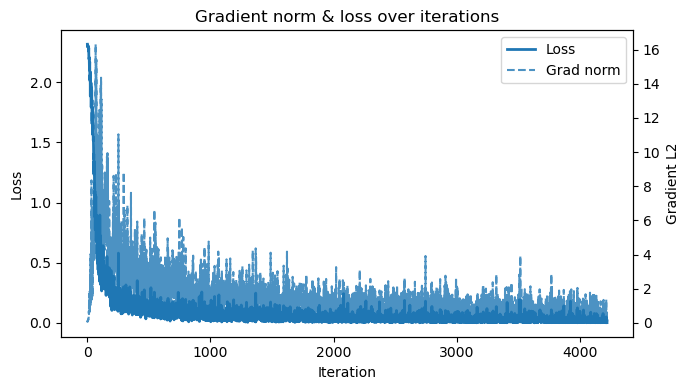

In [44]:
def grad_l2(model):
    s = 0.0
    for p in model.parameters():
        if p.grad is not None:
            s += float(torch.sum(p.grad.detach() ** 2))
    return math.sqrt(s)

def train_with_grad_logging(model, epochs=2, lr=1e-3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    g_hist, L_hist = [], []
    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            g_hist.append(grad_l2(model))
            L_hist.append(loss.item())
            opt.step()
    return np.array(g_hist), np.array(L_hist)


set_seed(123)
model = make_model("deep")  
g_hist, L_hist = train_with_grad_logging(model, epochs=EPOCHS_OPT, lr=LR_OPT)


SMOOTH = 0  
def movavg(a, k):
    if k <= 1: return a
    k = int(k)
    return np.convolve(a, np.ones(k)/k, mode="same")

g_plot = movavg(g_hist, SMOOTH)
L_plot = movavg(L_hist, SMOOTH)


it = np.arange(1, len(g_plot) + 1)
fig, ax1 = plt.subplots(figsize=(7, 4))

ln1 = ax1.plot(it, L_plot, label="Loss", linewidth=2)
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")


ax2 = ax1.twinx()
ln2 = ax2.plot(it, g_plot, label="Grad norm", linestyle="--", alpha=0.8)
ax2.set_ylabel("Gradient L2")

lines = ln1 + ln2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper right")

plt.title("Gradient norm & loss over iterations")
plt.tight_layout()
plt.show()


## What happerns when gradient is almost zero

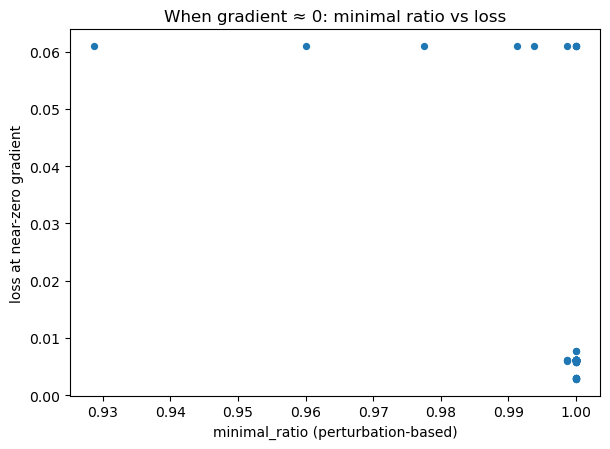

In [45]:
def f(x): return np.sin(5*np.pi*x)/(5*np.pi*x+1e-6)
Xs = torch.linspace(0.01,1,300).view(-1,1).to(device)
Ys = torch.from_numpy(f(Xs.cpu().numpy())).to(device).float()

class TinyMLP(nn.Module):
    def __init__(self, h=10):
        super().__init__()
        self.fc1 = nn.Linear(1,h); self.fc2 = nn.Linear(h,1)
    def forward(self,x): return self.fc2(F.relu(self.fc1(x)))

def loss_mse(m): return F.mse_loss(m(Xs), Ys)

def to_vec(model):
    return torch.cat([p.view(-1) for p in model.parameters()])

def from_vec(model, vec):
    i = 0
    for p in model.parameters():
        n = p.numel()
        p.data.copy_(vec[i:i+n].view_as(p)); i += n

def hessian_eigs(model):
    
    params = [p for p in model.parameters() if p.requires_grad]
    n = sum(p.numel() for p in params)
    v0 = torch.zeros(n, device=device)
    H = torch.zeros(n, n, device=device)
    loss = loss_mse(model)
    grads = torch.autograd.grad(loss, params, create_graph=True)
    g = torch.cat([t.reshape(-1) for t in grads])
    for i in range(n):
        Hi = torch.autograd.grad(g[i], params, retain_graph=True)
        H[:, i] = torch.cat([t.reshape(-1) for t in Hi])
    eigvals = torch.linalg.eigvalsh(H).detach().cpu().numpy()
    return eigvals

def minimal_ratio_sample(model, sigma=1e-3, samples=200):
    base = to_vec(model).detach()
    base_loss = float(loss_mse(model).item())
    higher = 0
    for _ in range(samples):
        from_vec(model, base + sigma*torch.randn_like(base))
        higher += float(loss_mse(model).item() > base_loss)
    from_vec(model, base)  # restore
    return higher / samples, base_loss

def find_stationary(seed=0, steps=200):
    set_seed(seed)
    m = TinyMLP(h=10).to(device)
    opt = torch.optim.LBFGS(m.parameters(), lr=1.0, max_iter=steps, history_size=10, line_search_fn="strong_wolfe")
    def closure():
        opt.zero_grad(); L = loss_mse(m); L.backward(); return L
    opt.step(closure)
    gnorm = torch.norm(torch.cat([p.grad.view(-1) for p in m.parameters() if p.grad is not None])).item()
    return m, gnorm


ratios, losses = [], []
for s in range(100):
    m, g = find_stationary(seed=1000+s)
    ratio_samp, loss_val = minimal_ratio_sample(m, sigma=0.03, samples=800)
    ratios.append(ratio_samp); losses.append(loss_val)

plt.figure(figsize=(6.2,4.6))
plt.scatter(ratios, losses, s=18)
plt.xlabel("minimal_ratio (perturbation-based)"); plt.ylabel("loss at near-zero gradient")
plt.title("When gradient ≈ 0: minimal ratio vs loss"); plt.tight_layout(); plt.show()


## HW 1-3 

## Can Network Fit random labels

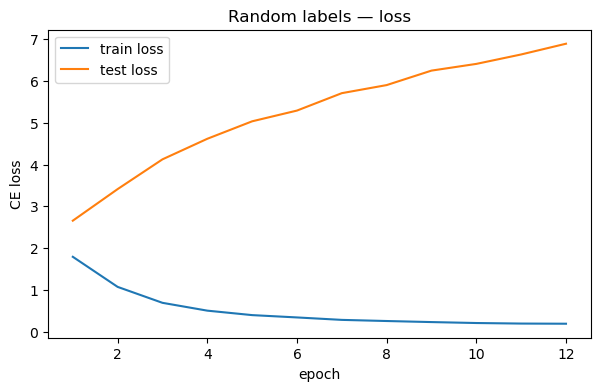

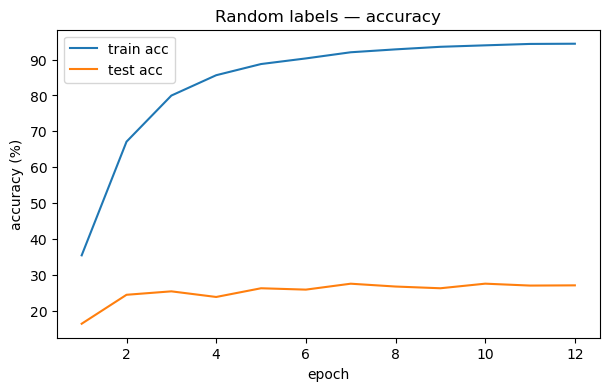

Final train acc: 94.4% | Final test acc: 27.0%


In [12]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np, math, matplotlib.pyplot as plt
from torchvision import datasets, transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])
train_set = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_set  = datasets.MNIST("./data", train=False, download=True, transform=transform)

class SmallCNN(nn.Module):
    def __init__(self, in_ch=1, num_classes=10, c1=32, c2=64):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, c1, 3, padding=1), nn.ReLU(),
            nn.Conv2d(c1, c2, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),                   
            nn.Conv2d(c2, c2, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),                   
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(c2, num_classes)
    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


class RandomLabelWrapper(Dataset):
    def __init__(self, base_ds, num_classes=10, seed=0):
        self.base = base_ds
        rng = np.random.default_rng(seed)
        perm = rng.permutation(num_classes)
        self.map = {i:int(perm[i]) for i in range(num_classes)}
    def __len__(self): return len(self.base)
    def __getitem__(self, i):
        x,y = self.base[i]
        return x, self.map[int(y)]

def accuracy(model, loader):
    model.eval(); correct = total = 0
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(1)
            correct += (pred==yb).sum().item(); total += yb.numel()
    return 100.0*correct/total

def train(model, train_loader, test_loader, epochs=10, lr=1e-3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    tr_loss, te_loss, tr_acc, te_acc = [], [], [], []
    for _ in range(epochs):
        model.train()
        running = 0; n=0; correct=total=0
        for xb,yb in train_loader:
            xb,yb = xb.to(device), yb.to(device)
            opt.zero_grad(); logits = model(xb); loss = loss_fn(logits,yb)
            loss.backward(); opt.step()
            running += loss.item()*xb.size(0); n += xb.size(0)
            correct += (logits.argmax(1)==yb).sum().item(); total += yb.numel()
        tr_loss.append(running/n); tr_acc.append(100.0*correct/total)

        # test
        model.eval(); running=n=0
        with torch.no_grad():
            for xb,yb in test_loader:
                xb,yb = xb.to(device), yb.to(device)
                loss = loss_fn(model(xb), yb)
                running += loss.item()*xb.size(0); n += xb.size(0)
        te_loss.append(running/n); te_acc.append(accuracy(model, test_loader))
    return {"tr_loss":tr_loss,"te_loss":te_loss,"tr_acc":tr_acc,"te_acc":te_acc}


def subset_loader(ds, n, batch, shuffle):
    idx = np.random.default_rng(0).choice(len(ds), size=n, replace=False)
    return DataLoader(Subset(ds, idx), batch_size=batch, shuffle=shuffle, num_workers=0, pin_memory=True)

train_rand = RandomLabelWrapper(train_set, seed=123)
tr_loader = subset_loader(train_rand, 12000, 128, True)   
te_loader = DataLoader(test_set, batch_size=512, shuffle=False, num_workers=0, pin_memory=True)

model = SmallCNN().to(device)
hist = train(model, tr_loader, te_loader, epochs=12, lr=1e-3)


ep = range(1, len(hist["tr_loss"])+1)
plt.figure(figsize=(7,4)); 
plt.plot(ep, hist["tr_loss"], label="train loss"); plt.plot(ep, hist["te_loss"], label="test loss")
plt.xlabel("epoch"); plt.ylabel("CE loss"); plt.legend(); plt.title("Random labels — loss"); plt.show()
plt.figure(figsize=(7,4));
plt.plot(ep, hist["tr_acc"], label="train acc"); plt.plot(ep, hist["te_acc"], label="test acc")
plt.xlabel("epoch"); plt.ylabel("accuracy (%)"); plt.legend(); plt.title("Random labels — accuracy"); plt.show()
print(f"Final train acc: {hist['tr_acc'][-1]:.1f}% | Final test acc: {hist['te_acc'][-1]:.1f}%")


## Number of parameters vs Generalization 

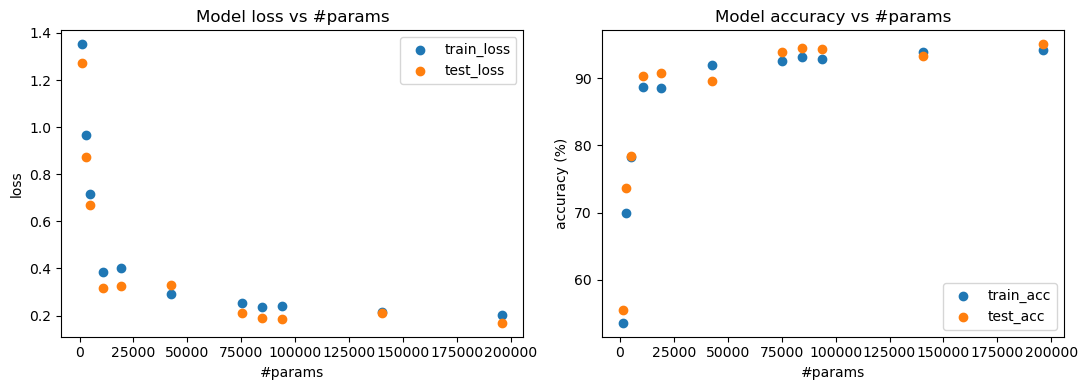

In [15]:
def count_params(m): return sum(p.numel() for p in m.parameters())

def mk_net(c1,c2): 
    return SmallCNN(c1=c1, c2=c2).to(device)

cfgs = [(c1,c2) for c1,c2 in 
        [(8,8),(12,12),(16,16),(24,24),(32,32),(48,48),(64,64),
         (80,64),(96,64),(112,80),(128,96)]]

tr_loader = subset_loader(train_set, 20000, 128, True)  
te_loader = DataLoader(test_set, batch_size=512, shuffle=False, num_workers=0, pin_memory=True)

results = []
for (c1,c2) in cfgs:
    m = mk_net(c1,c2)
    H = train(m, tr_loader, te_loader, epochs=5, lr=1e-3)
    results.append({
        "params": count_params(m),
        "train_loss": H["tr_loss"][-1], "test_loss": H["te_loss"][-1],
        "train_acc": H["tr_acc"][-1],   "test_acc": H["te_acc"][-1]
    })


P  = np.array([r["params"] for r in results])
tL = np.array([r["train_loss"] for r in results]); eL = np.array([r["test_loss"] for r in results])
tA = np.array([r["train_acc"] for r in results]); eA = np.array([r["test_acc"] for r in results])

plt.figure(figsize=(11,4))
plt.subplot(1,2,1); plt.scatter(P, tL, label="train_loss"); plt.scatter(P, eL, label="test_loss")
plt.xlabel("#params"); plt.ylabel("loss"); plt.title("Model loss vs #params"); plt.legend()
plt.subplot(1,2,2); plt.scatter(P, tA, label="train_acc"); plt.scatter(P, eA, label="test_acc")
plt.xlabel("#params"); plt.ylabel("accuracy (%)"); plt.title("Model accuracy vs #params"); plt.legend()
plt.tight_layout(); plt.show()


### Interpolate between two trained CNNs (different training: batch size & LR)

/home/omayeka/miniconda3/envs/nerfstudio/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


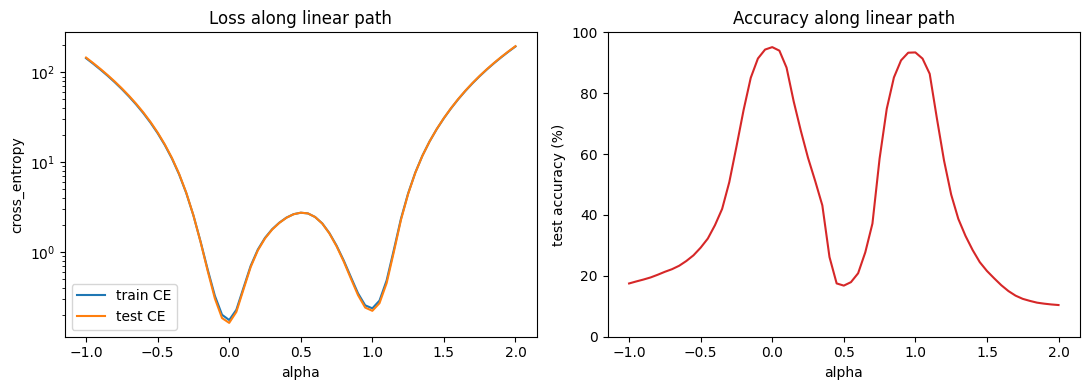

In [7]:
import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


def mk_net(c1=32, c2=64):
    return ShallowCNN(in_ch, c1, c2, num_classes).to(device)
    # return DeepCNN(in_ch, [c1, c2], num_classes).to(device)


@torch.no_grad()
def accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb).argmax(1)
        correct += (pred == yb).sum().item()
        total   += yb.numel()
    return 100.0 * correct / total

@torch.no_grad()
def eval_ce(loader, model):
    model.eval()
    ce = nn.CrossEntropyLoss(reduction='sum')
    tot, n = 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        tot += ce(model(xb), yb).item()
        n   += xb.size(0)
    return tot / n


def train(model, train_loader, test_loader, epochs=5, lr=1e-3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    ce  = nn.CrossEntropyLoss()
    hist = {"train_loss":[], "test_loss":[], "train_acc":[], "test_acc":[]}
    for _ in range(epochs):
        model.train()
        run, n = 0.0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = ce(model(xb), yb)
            loss.backward()
            opt.step()
            run += loss.item() * xb.size(0); n += xb.size(0)
        hist["train_loss"].append(run/n)
        hist["test_loss"].append(eval_ce(test_loader, model))
        hist["train_acc"].append(accuracy(model, train_loader))
        hist["test_acc"].append(accuracy(model, test_loader))
    return hist


from torch.utils.data import DataLoader

def train_cnn(bs=128, lr=1e-3, epochs=5, seed=0):
    g = torch.Generator().manual_seed(seed)
    tr_loader = DataLoader(train_set, batch_size=bs, shuffle=True,  num_workers=0, generator=g)
    te_loader = DataLoader(test_set,  batch_size=512, shuffle=False, num_workers=0)
    m = mk_net(32, 64)
    H = train(m, tr_loader, te_loader, epochs=epochs, lr=lr)
    return m, H, tr_loader, te_loader

m1, H1, tr_loader1, te_loader = train_cnn(bs=64,   lr=1e-3, epochs=6, seed=1)
m2, H2, tr_loader2, _         = train_cnn(bs=1024, lr=1e-2, epochs=6, seed=2)


tr_loader_plot = DataLoader(train_set, batch_size=512, shuffle=False, num_workers=0)


def copy_like(src, dst):
    for (_, p), (_, q) in zip(src.named_parameters(), dst.named_parameters()):
        q.data.copy_(p.data)

def interpolate(model_a, model_b, alpha):
    m = mk_net(c1=32, c2=64).to(device)
    with torch.no_grad():
        for (_, pa), (_, pb), pc in zip(model_a.named_parameters(),
                                        model_b.named_parameters(),
                                        m.parameters()):
            pc.copy_((1.0 - alpha) * pa + alpha * pb)
    return m


alphas   = np.linspace(-1.0, 2.0, 61)
train_ce, test_ce, test_acc = [], [], []

for a in alphas:
    m = interpolate(m1, m2, a)
    train_ce.append(eval_ce(tr_loader_plot, m))
    test_ce.append(eval_ce(te_loader,      m))
    test_acc.append(accuracy(m, te_loader))


fig, ax = plt.subplots(1, 2, figsize=(11, 4))

ax[0].plot(alphas, train_ce, label="train CE")
ax[0].plot(alphas, test_ce,  label="test CE")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("cross_entropy")
ax[0].set_title("Loss along linear path")
ax[0].set_yscale("log")     
ax[0].legend()

ax[1].plot(alphas, test_acc, color="tab:red")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("test accuracy (%)")
ax[1].set_ylim(0, 100)    
ax[1].set_title("Accuracy along linear path")

plt.tight_layout()
plt.show()



### Flatness v.s. Generalization — Part 2 (MNIST)

Training with batch_size=16 (steps=6000) &
Training with batch_size=32 (steps=6000) &
Training with batch_size=64 (steps=6000) &
Training with batch_size=128 (steps=6000) &
Training with batch_size=256 (steps=6000) &
Training with batch_size=512 (steps=6000) &
Training with batch_size=1024 (steps=6000) &


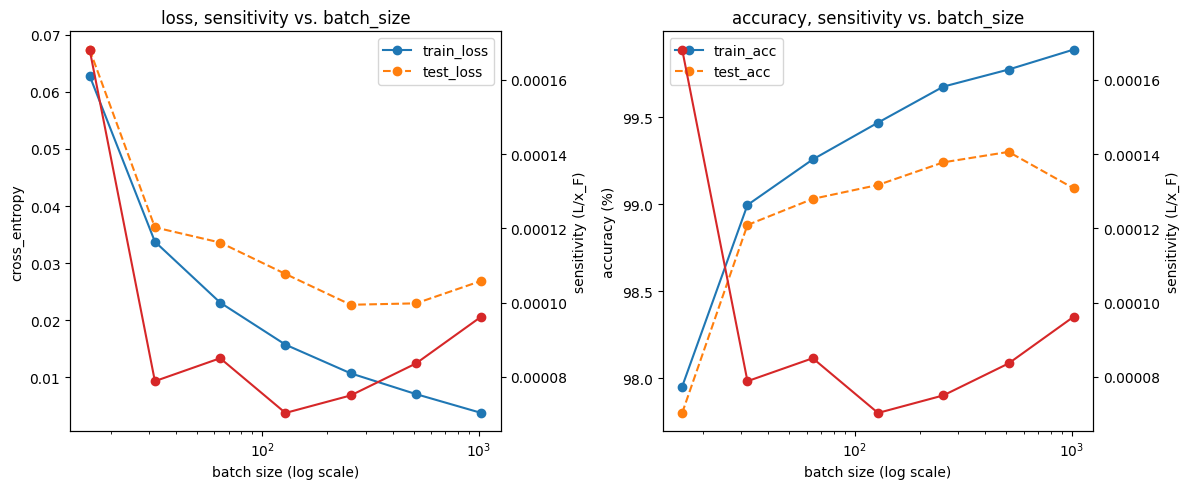

In [12]:

import math, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


def set_seed(seed=0):
    import random
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

set_seed(0)


try:
    train_set, test_set
except NameError:
    from torchvision import datasets, transforms
    DATASET = "mnist" 

    if DATASET.lower() == "mnist":
        tfm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        train_set = datasets.MNIST(root="./data", train=True,  download=True, transform=tfm)
        test_set  = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)
    else:
        # CIFAR-10 normalization
        tfm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2470, 0.2435, 0.2616))
        ])
        train_set = datasets.CIFAR10(root="./data", train=True,  download=True, transform=tfm)
        test_set  = datasets.CIFAR10(root="./data", train=False, download=True, transform=tfm)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_ch = train_set[0][0].shape[0]
num_classes = len(getattr(train_set, "classes", list(range(10))))


class SimpleCNN(nn.Module):
    def __init__(self, in_ch=1, widths=(32,64,128), num_classes=10):
        super().__init__()
        c1,c2,c3 = widths
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, c1, 3, padding=1), nn.ReLU(),
            nn.Conv2d(c1, c1, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(c1, c2, 3, padding=1), nn.ReLU(),
            nn.Conv2d(c2, c2, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(c2, c3, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(c3, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss(reduction="sum")
    tot_loss, tot_correct, tot_n = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        tot_loss += float(loss_fn(logits, yb).item())
        tot_correct += int((logits.argmax(1) == yb).sum().item())
        tot_n += yb.size(0)
    return tot_loss/tot_n, tot_correct/tot_n

def compute_sensitivity(model, loader, max_items=2048):
    """
    Sensitivity := average Frobenius norm of d(CE)/dx over data.
    We average over 'max_items' images for stability.
    """
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    tot, seen = 0.0, 0
    for xb, yb in loader:
        if seen >= max_items: break
        k = min(xb.size(0), max_items - seen)
        xb, yb = xb[:k].to(device), yb[:k].to(device)
        xb.requires_grad_(True)
        loss = loss_fn(model(xb), yb)
        (grad_x,) = torch.autograd.grad(loss, xb, retain_graph=False, create_graph=False)
        g = grad_x.view(k, -1).norm(p=2, dim=1).mean() 
        tot += float(g.item())
        seen += k
    return tot / max(1, seen // k)


def train_fixed_steps(batch_size=64, lr=1e-3, steps=6000):
    """
    Train for a *fixed number of optimizer steps* so each batch size
    sees the same number of updates (matches slide's assumption).
    """
    tr_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    te_loader = DataLoader(test_set,  batch_size=512,       shuffle=False, num_workers=0)

    model = SimpleCNN(in_ch=in_ch, num_classes=num_classes).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    it = iter(tr_loader)
    for s in range(steps):
        try:
            xb, yb = next(it)
        except StopIteration:
            it = iter(tr_loader); xb, yb = next(it)
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        opt.step()

    tr_loss, tr_acc = evaluate(model, DataLoader(train_set, batch_size=512, shuffle=False))
    te_loss, te_acc = evaluate(model, te_loader)
    sens = compute_sensitivity(model, te_loader, max_items=2048)
    return dict(batch_size=batch_size, train_loss=tr_loss, test_loss=te_loss,
                train_acc=tr_acc, test_acc=te_acc, sensitivity=sens)


BATCH_SIZES = [16, 32, 64, 128, 256, 512, 1024]
LR = 1e-3
STEPS = 6000  

results = []
for bs in BATCH_SIZES:
    print(f"Training with batch_size={bs} (steps={STEPS}) &")
    set_seed(123) 
    results.append(train_fixed_steps(batch_size=bs, lr=LR, steps=STEPS))


xs = np.array([r["batch_size"] for r in results], float)
tr_loss = np.array([r["train_loss"] for r in results])
te_loss = np.array([r["test_loss"]  for r in results])
tr_acc  = 100*np.array([r["train_acc"] for r in results])
te_acc  = 100*np.array([r["test_acc"]  for r in results])
sens    = np.array([r["sensitivity"]  for r in results])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharex=True)


ax1.plot(xs, tr_loss, marker='o', label='train_loss')
ax1.plot(xs, te_loss, marker='o', linestyle='--', label='test_loss')
ax1.set_xscale('log')
ax1.set_xlabel('batch size (log scale)')
ax1.set_ylabel('cross_entropy')

ax1b = ax1.twinx()
ax1b.plot(xs, sens, color='tab:red', marker='o', label='sensitivity')
ax1b.set_ylabel('sensitivity (L/x_F)')
ax1.legend(loc='best')
ax1.set_title('loss, sensitivity vs. batch_size')


ax2.plot(xs, tr_acc, marker='o', label='train_acc')
ax2.plot(xs, te_acc, marker='o', linestyle='--', label='test_acc')
ax2.set_xscale('log')
ax2.set_xlabel('batch size (log scale)')
ax2.set_ylabel('accuracy (%)')
ax2b = ax2.twinx()
ax2b.plot(xs, sens, color='tab:red', marker='o', label='sensitivity')
ax2b.set_ylabel('sensitivity (L/x_F)')
ax2.legend(loc='best')
ax2.set_title('accuracy, sensitivity vs. batch_size')

plt.tight_layout(); plt.show()
